In [1]:
import numpy as np
from vlasov import Efield,Species

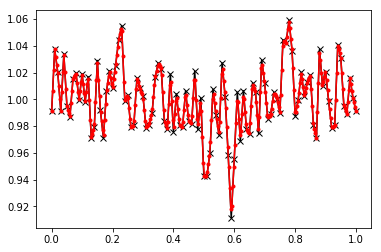

In [2]:
e=Efield(nintervals=100)
ion=Species(nparticles=100000,mass=1.,charge=1.,temperature=3.)
e.deposit(ion)
e.plot()

In [3]:
print(np.sum(ion.w))
print(np.sum(e.charge_density)*e.dx)


1.0
1.0099101105547523


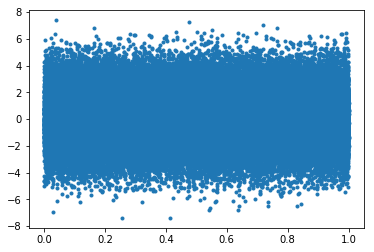

In [23]:
ion.plot()
ion.push(0.01,e)